In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import networkx as nx

from matching.src import utils
from matching.src.test import validate
from matching.src.args import Args, load_args
from matching.src.model import build_model
from matching.src.dataset import get_dataset, gen_batch, gen_data_loaders, batch_nx_graphs

In [2]:
print(f"device is {utils.get_device()}")
args = load_args( Args().model_args_path )
args.test = True
model = build_model( args )
dataset = get_dataset(node_size=100)
results = validate( args, model, dataset )
acc, prec, recall, auroc, avg_prec, tn, fp, fn, tp = results
print( f"A: {acc:.4f} / P: {prec:.4f} / R: {recall:.4f}. AR: {auroc:.4f} / AP: {avg_prec:.4f}" )
print( f"TN: {tn} / FP: {fp} / FN: {fn} / TP: {tp}" )

device is cpu
A: 0.7573 / P: 0.6849 / R: 0.9531. AR: 0.8194 / AP: 0.7452.
TN: 575 / FP: 449 / FN: 48 / TP: 976


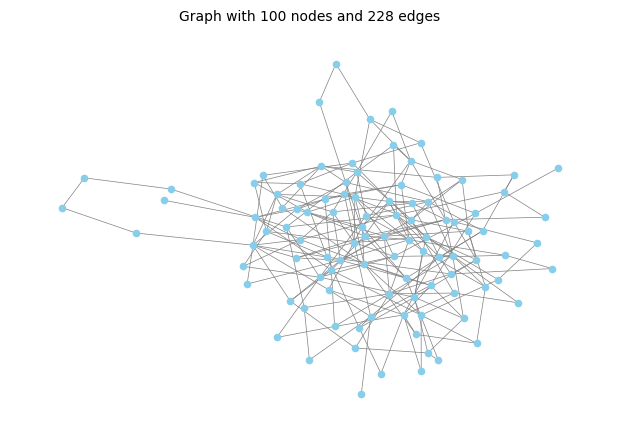

In [3]:
dataset_example = dataset[1][0]
utils.plot_graph(dataset_example)

In [4]:
test_loaders = gen_data_loaders(args.val_size, args.batch_size)
example_batch = None
example_batch_graphs = None
for batch_target, batch_neg_target, batch_neg_query in zip(*test_loaders):
    example_batch = gen_batch( dataset, batch_target, batch_neg_target, batch_neg_query, True )
    example_batch_graphs = gen_batch( dataset, batch_target, batch_neg_target, batch_neg_query, True, batched=False )
    break
   
pos_target_graph, pos_query_graph, neg_target_graph, neg_query_graph = example_batch_graphs 
pos_target, pos_query, neg_target, neg_query = example_batch

test_labels = torch.tensor([1]*(pos_target.num_graphs if neg_target else 0) + [0]*neg_target.num_graphs).to(utils.get_device())
model.eval()
with torch.no_grad():
    
    emb_pos_target, emb_pos_query = model.emb_model(pos_target), model.emb_model(pos_query)
    emb_neg_target, emb_neg_query = model.emb_model(neg_target), model.emb_model(neg_query)
    
    emb_targets = torch.cat((emb_pos_target, emb_neg_target), dim=0)
    emb_queries = torch.cat((emb_pos_query, emb_neg_query), dim=0)
                
    pred = model(emb_targets, emb_queries)
    raw_pred = model.predict(pred)
    
    pred = model.clf_model(raw_pred.unsqueeze(1)).argmax(dim=-1)
    raw_pred *= -1
    
print(pred)
print(raw_pred)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1])
tensor([-1.5349e-03, -3.6448e-03, -4.5069e-03, -2.9065e-05, -1.3520e-03,
        -0.0000e+00, -2.1152e-04, -2.9903e-04, -0.0000e+00, -1.0220e-02,
        -0.0000e+00, -0.0000e+00, -1.4303e-02, -5.7763e-02, -5.3227e-03,
        -1.8971e-03, -1.9228e-04, -1.3520e-03, -3.3856e-02, -3.2480e-04,
        -0.0000e+00, -3.6448e-03, -2.2620e-02, -1.1590e-03, -0.0000e+00,
        -1.9913e-04, -6.8275e-03, -2.4443e-03, -3.9096e-03, -4.0273e-04,
        -1.5020e-04, -2.7884e-03, -3.1111e-01, -4.5520e-01, -1.9185e-01,
        -1.6693e-02, -3.7532e-02, -5.1212e-05, -0.0000e+00, -4.2060e-02,
        -4.2843e-02, -2.4003e+00, -2.2666e-03, -1.4069e-01, -3.9411e+00,
        -2.9970e-01, -4.3653e-02, -6.9443e+00, -9.4357e-03, -1.7862e+00,
        -3.0142e-01, -0.0000e+00, -1.5620e+00, -1.352

In [5]:
test_idx = 0

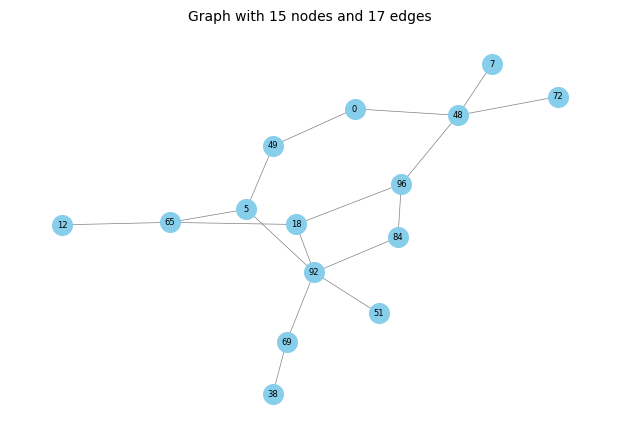

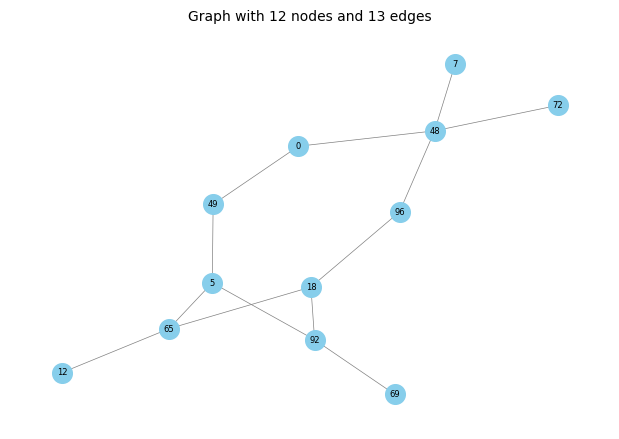

Is query is subgraph - model: True / actual  True


In [6]:
utils.plot_graph(pos_target_graph[test_idx], with_label=True)
utils.plot_graph(pos_query_graph[test_idx], with_label=True)
print(f"Is query is subgraph - model: {pred[test_idx] == True} / actual  {test_labels[test_idx] == True}")

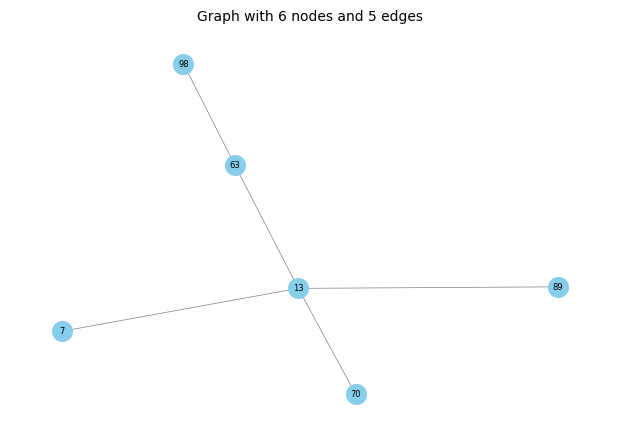

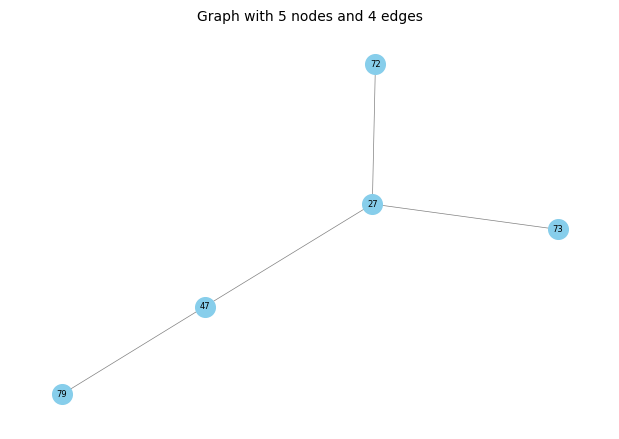

Is query is subgraph - model: False / actual: False


In [7]:
utils.plot_graph(neg_target_graph[test_idx], with_label=True)
utils.plot_graph(neg_query_graph[test_idx], with_label=True)
print(f"Is query is subgraph - model: {pred[len(pos_target_graph) + test_idx] == True} / actual: {test_labels[len(pos_target_graph) + test_idx] == True}")

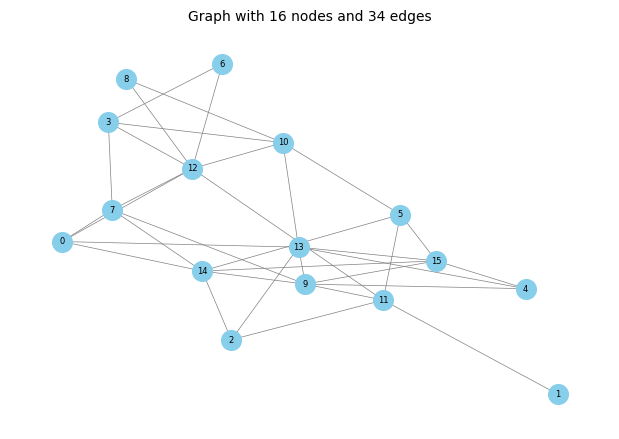

In [37]:
target = nx.gnp_random_graph(16, 0.25)
"""
target = nx.Graph()
target.add_edge(1, 2)
target.add_edge(1, 3)
target.add_edge(1, 5)
target.add_edge(2, 3)
target.add_edge(3, 4)
target.add_edge(4, 5)
target.add_edge(2, 6)
"""
utils.plot_graph(target, with_label=True)

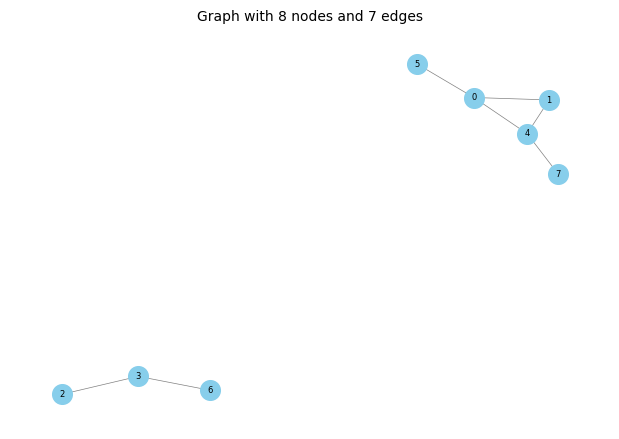

In [46]:
query = nx.gnp_random_graph(8, 0.25)
"""
query = nx.Graph()
query.add_edge(1, 2)
query.add_edge(2, 3)
query.add_edge(3, 1)
query.add_edge(3, 4)
"""
utils.plot_graph(query, with_label=True)

0 0 -7.073590278625488
0 1 -5.490222930908203
0 2 -7.400230407714844
0 3 -7.137611389160156
0 4 -7.992554664611816
0 5 -7.574919700622559
0 6 -9.878268241882324
0 7 -7.061771869659424
0 8 -9.401326179504395
0 9 -6.007225513458252
0 10 -6.396478652954102
0 11 -6.873203754425049
0 12 -6.1023759841918945
0 13 -6.933497428894043
0 14 -7.049068927764893
0 15 -6.6201090812683105
1 0 -5.433329105377197
1 1 -5.135903358459473
1 2 -5.570649147033691
1 3 -5.461270332336426
1 4 -5.787350654602051
1 5 -5.6388092041015625
1 6 -6.232422828674316
1 7 -5.428116321563721
1 8 -6.137016296386719
1 9 -4.89300537109375
1 10 -5.106651306152344
1 11 -5.342601299285889
1 12 -4.946958541870117
1 13 -5.370423793792725
1 14 -5.422493934631348
1 15 -5.220870018005371
2 0 -3.78633451461792
2 1 -4.348553657531738
2 2 -3.8454456329345703
2 3 -3.7985496520996094
2 4 -3.934061050415039
2 5 -3.8739306926727295
2 6 -4.101344108581543
2 7 -3.7840447425842285
2 8 -4.0715861320495605
2 9 -3.5310707092285156
2 10 -3.6363506

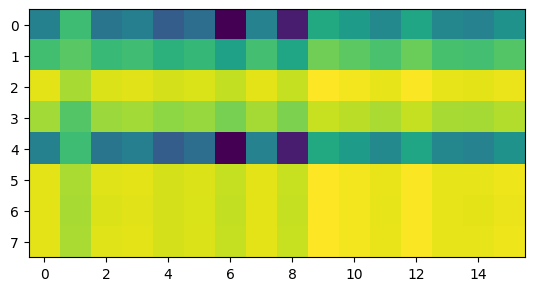

In [53]:
mat = np.zeros((len(query), len(target)))
for i, u in enumerate(query.nodes):
    for j, v in enumerate(target.nodes):
        batch = batch_nx_graphs([query, target], anchors=[u, v])
        embs = model.emb_model(batch)
        pred = model(embs[1].unsqueeze(0), embs[0].unsqueeze(0))
        raw_pred = model.predict(pred)
        raw_pred = torch.log(raw_pred)
        print(i,j,raw_pred.item())
        mat[i][j] = raw_pred.item()
        
plt.imshow(mat, interpolation="nearest")